## Train and Validation a CNN Model for IFCB Data 

Pull in necessary python modules

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import numpy as np

import cv2

Point to image metadata and file locations

In [2]:
tsv_file_path = '../data/ecotaxa_export_3857_20201203_2323.tsv'
imagery_fp = "../../../Data/all_imagery/*.png" # this imagery should all be in the same directory

Where will you save the model and the scaler for scaling the handcrafted features?

In [3]:
model_save_fp = '../model_weights_230221_1.hdf5'
output_scaler_fp = 'scaler_feats_230221_1.gz'

Open the metadata with pandas

In [4]:
img_md_subset = pd.read_csv(tsv_file_path, sep='\t')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (265) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


How many files in the dataframe?

In [5]:
len(img_md_subset)

25401

### Setting up data for model training

These are the columns from the dataframe we don't want:

In [6]:
cols_not_for_training = ['img_file_name',
'object_id',
'object_link',
'object_lat',
'object_lon',
'object_date',
'object_time',
'object_depth_min',
'object_depth_max',
'object_annotation_category',
'object_annotation_date',
'object_annotation_hierarchy',
'object_annotation_hierarchy.1',
'object_annotation_person_email',
'object_annotation_person_name',
'object_annotation_status',
'object_annotation_time',
'object_score',
'acq_id',
'acq_instrument',
'acq_resolution_pixels_per_micron',
'process_id',
'process_soft',
'process_soft_version',
'process_script',
'process_script_version',
'process_library',
'process_library_version',
'process_date',
'process_time',
'sample_id',
'sample_source',
'sample_flag',
'sample_cruise',
'sample_vessel',
'sample_reference',
'sample_station',
'sample_cast',
'sample_source_id', 
'sample_culture_species',
'sample_concentration',
'sample_dataportal_descriptor',                        
'object_roi_number',
'Unnamed: 0',
'index',
'merged_category',
'level_0',
'sample_experiment_state',
'sample_experiment_dilution', 
'sample_experiment_light_level',
'sample_experiment_nutrients',
'object_area_over_perimeter_squared',            
'object_area_over_perimeter',                       
'object_h90_over_hflip',                           
'object_h90_over_h180',                              
'object_hflip_over_h180',                         
'object_summed_convex_perimeter_over_perimeter',   
'object_rotated_bounding_box_solidity']

### Filtering classes in the data

Visualize the classes that have less than `rare_count`

In [24]:
rare_count = 400

unique_validated = img_md_subset[img_md_subset.object_annotation_status == 'validated'].groupby('object_annotation_category')['object_id'].nunique()

rare_classes = unique_validated[unique_validated <= rare_count]

#val_img_subset = val_img_subset[val_img_subset['object_annotation_category'].isin(list(rare_classes.index))]
rare_classes

object_annotation_category
Banquisia belgicae          64
Chaetoceros single         295
Corethron                  116
Dictyochales               167
Dinophyceae                165
Eucampia                   141
Eucampia chain              97
Gymnodinium                263
Gyrodinium                 166
Licmophora                 148
Membraneis                 256
Navicula                   353
Odontella sp.               80
Proboscia sp.              243
Rhizosolenia               140
Tintinnida                  50
Warnowia                    53
bubble                     352
centric                    142
centric 4 temp             364
centric 6 temp             262
dinoflagellate-i           353
dinoflagellate-iii         270
pennate<Bacillariophyta     57
t006                        68
t007                       234
t009                       147
t012                       376
t013                       340
t019                       301
t020                       211
temp cylindr

#### drop all unwanted classes

In [25]:
# Here are groups we can cut:
classes_to_drop = ['Banquisia belgicae',
'Dinophyceae',
'pennate<Bacillariophyta',
'Licmophora',
'Rhizosolenia',
'centric 4 temp',
'centric 6 temp',
't005',
't006',
't009',
't019',
't020',
'Warnowia',
'multiple<other']
print(len(img_md_subset))
img_md_subset = img_md_subset.drop(img_md_subset[img_md_subset.object_annotation_category.isin(classes_to_drop)].index)
print(len(img_md_subset))

25401
22380


#### merge some classes

In [26]:
img_md_subset[img_md_subset.object_annotation_category == 'Tintinnida'] = 'Ciliophora'
img_md_subset[img_md_subset.object_annotation_category == 'Odontella sp.'] = 'chain<centric'
img_md_subset[img_md_subset.object_annotation_category == 'Eucampia chain'] = 'chain<centric'
len(img_md_subset)

22380

#### Filter this data to only use validated samples

In [27]:
val_subset = img_md_subset[img_md_subset.object_annotation_status == 'validated']
len(val_subset)

22153

### Getting Images Organized

In [28]:
import glob, os

fn_list = []
for file in glob.glob(imagery_fp):
    fn_list.append(file)
    
print(len(fn_list))

fn_edit = [x.split('/')[-1][:-4] for x in fn_list]

5806675


Only use data where we have both labels and imagery

In [29]:
val_img_subset = val_subset[val_subset['object_id'].isin(fn_edit)]
len(val_img_subset)

22032

### filter out images based on size

Currently filtering based on a major axis < 25 pixels

In [30]:
small_object_ids = []

for index, row in val_img_subset.iterrows():
    if row['object_major_axis_length'] < 25:
        small_object_ids.append(row['object_id'])
len(small_object_ids)

2332

Check out the sizes of the imagery major/minor axis and the x and y width

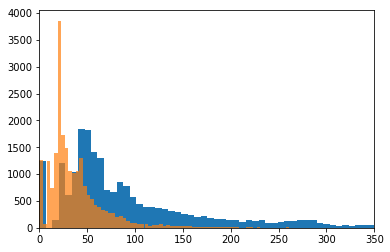

In [31]:
plt.hist(val_img_subset['object_major_axis_length'].values.astype(np.float16), bins=250)
plt.hist(val_img_subset['object_minor_axis_length'].values.astype(np.float16),alpha=0.7, bins=150)
plt.xlim(0,350)
plt.show()

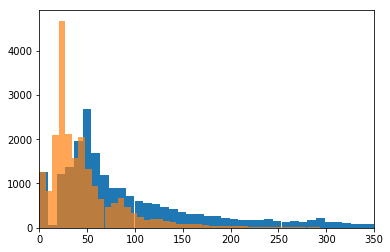

In [32]:
plt.hist(val_img_subset['object_bounding_box_xwidth'].values.astype(np.float16), bins=150)
plt.hist(val_img_subset['object_bounding_box_ywidth'].values.astype(np.float16),alpha=0.7, bins=150)
plt.xlim(0,350)
plt.show()

Look at the major/minor axis distribution of the data without the data <25 pix

(0, 350)

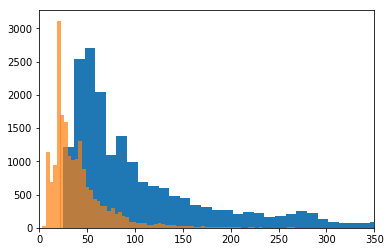

In [33]:
plt.hist(val_img_subset[~val_img_subset['object_id'].isin(small_object_ids)]['object_major_axis_length'].values.astype(np.float16), bins=150)
plt.hist(val_img_subset[~val_img_subset['object_id'].isin(small_object_ids)]['object_minor_axis_length'].values.astype(np.float16), alpha=0.7, bins=150)
plt.xlim(0,350)

Create dataframe with only the small data to inspect what is in it and see some example images

In [34]:
small_df = val_img_subset[val_img_subset['object_id'].isin(small_object_ids)]

In [35]:
with pd.option_context('display.max_rows', 200):
    print(small_df.groupby('object_annotation_category')['object_id'].nunique())

object_annotation_category
Amphiprora              1
Dactyliosolen           7
Phaeocystis            10
Pyramimonas            10
badfocus<artefact    1194
bead                  520
bubble                  6
centric 3 temp          4
detritus                1
pennate 1 temp          4
pennate 2 temp          1
t002                  556
t012                   18
Name: object_id, dtype: int64


t002


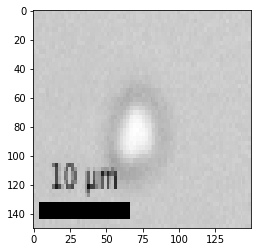

bead


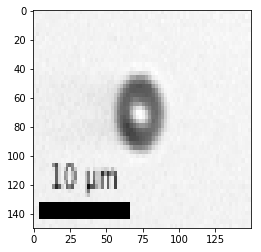

bead


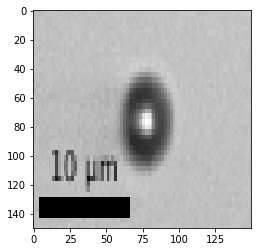

t002


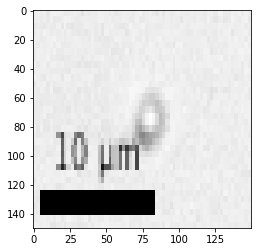

bead


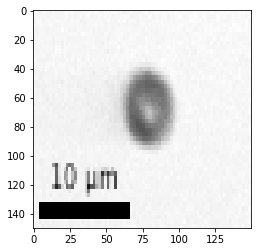

badfocus<artefact


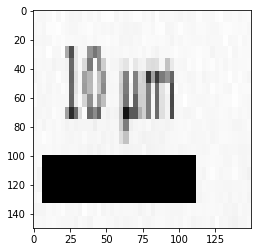

t012


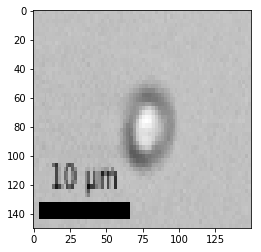

badfocus<artefact


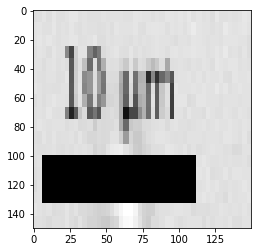

badfocus<artefact


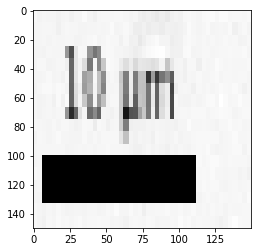

badfocus<artefact


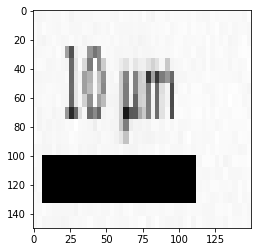

badfocus<artefact


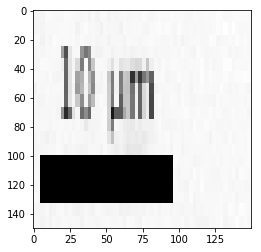

t002


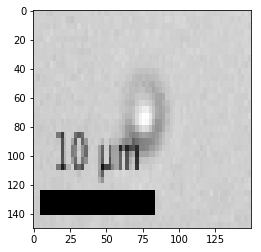

badfocus<artefact


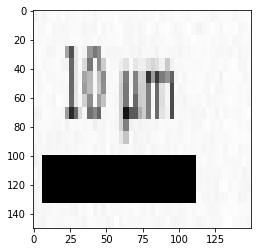

badfocus<artefact


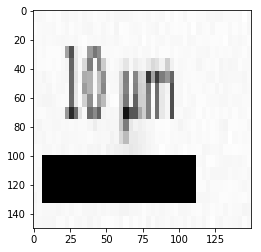

t002


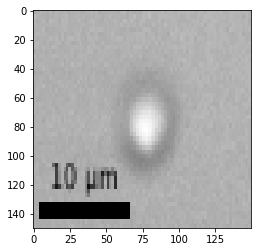

t002


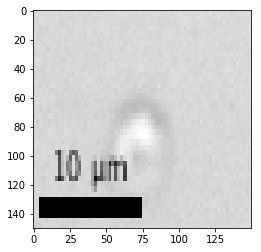

bead


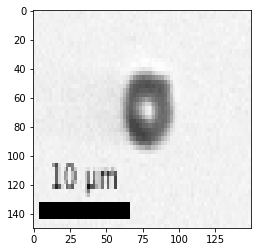

t002


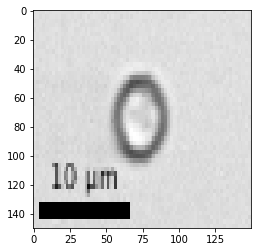

badfocus<artefact


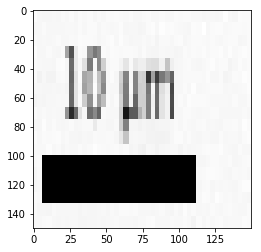

badfocus<artefact


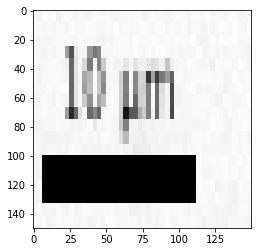

badfocus<artefact


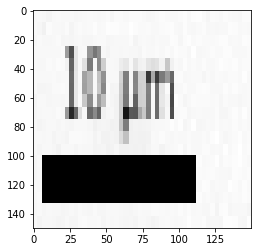

t002


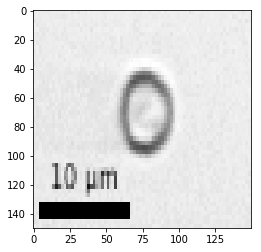

t002


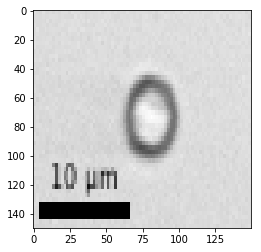

bead


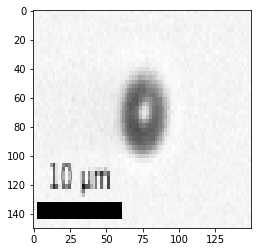

t002


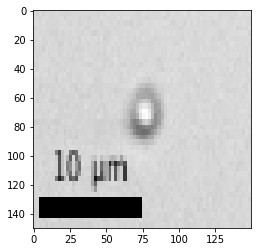

badfocus<artefact


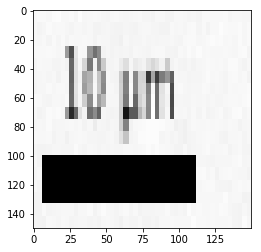

t002


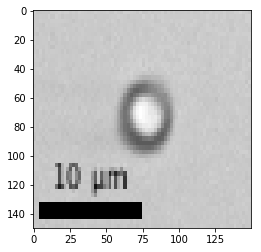

t002


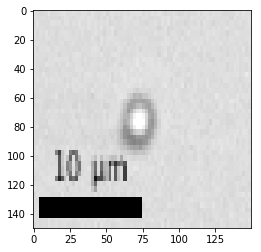

badfocus<artefact


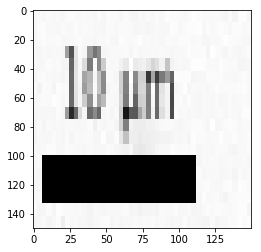

bead


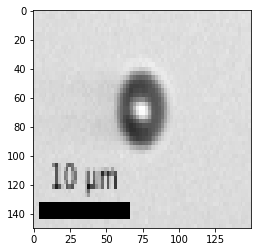

t002


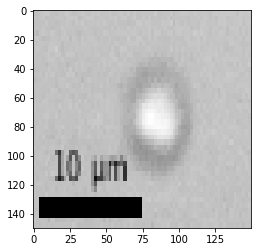

badfocus<artefact


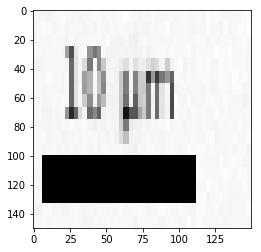

badfocus<artefact


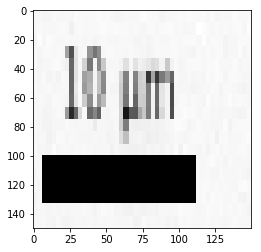

badfocus<artefact


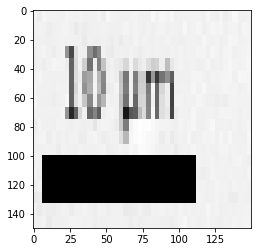

badfocus<artefact


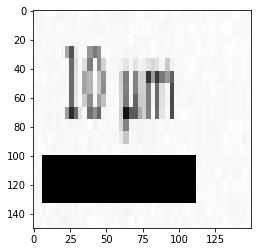

badfocus<artefact


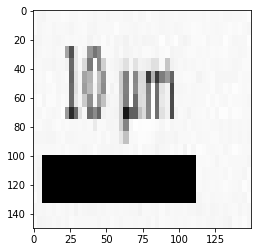

badfocus<artefact


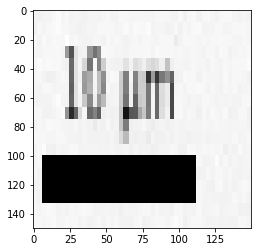

badfocus<artefact


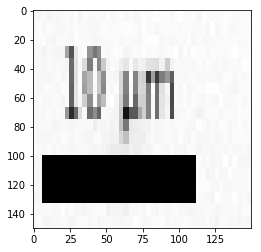

badfocus<artefact


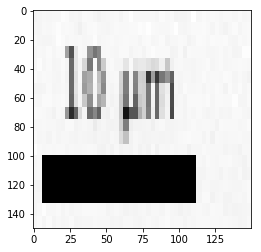

t002


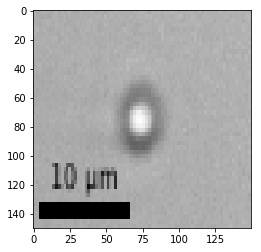

In [36]:
import cv2
from tensorflow.keras.preprocessing import image


for index, row in small_df.sample(n=40).iterrows():
    print(row['object_annotation_category'])
    #im = cv2.imread('../../../Data/all_imagery/'+row['object_id']+'.png', cv2.IMREAD_GRAYSCALE)
    im = image.load_img('../../../Data/all_imagery/'+row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    plt.imshow(image.img_to_array(im)[:,:,0], cmap="Greys_r")
    plt.show()

#### cut out the small cells

In [37]:
val_img_subset = val_img_subset[~val_img_subset['object_id'].isin(small_object_ids)]

Only use classes with `min_count` or more samples

In [38]:
min_count = 50

unique_validated = val_img_subset.groupby('object_annotation_category')['object_id'].nunique()

sufficient_classes = unique_validated[unique_validated >= min_count]

val_img_subset = val_img_subset[val_img_subset['object_annotation_category'].isin(list(sufficient_classes.index))]

See the remaining classes and how many are in each

In [39]:
with pd.option_context('display.max_rows', 200):
    print(val_img_subset.groupby('object_annotation_category')['object_id'].nunique())
    print(len(val_img_subset.groupby('object_annotation_category')))

object_annotation_category
Amphiprora                   490
Chaetoceros single           295
Chaetoceros<Mediophyceae     739
Ciliophora                   405
Corethron                    116
Cryptophyta                 1193
Cylindrotheca                443
Dactyliosolen                429
Dictyochales                 167
Eucampia                     141
Gymnodinium                  263
Gyrodinium                   166
Katodinium                   454
Membraneis                   256
Navicula                     353
Nitzschia frigida            834
Phaeocystis                 1010
Proboscia sp.                243
Pseudo-Nitzschia chain      1045
Pyramimonas                  887
bubble                       346
centric                      142
centric 1 temp               595
centric 2 temp               859
centric 3 temp               444
chain<centric                562
chain<pennate                531
detritus                     896
dinoflagellate-i             353
dinoflagellate-i

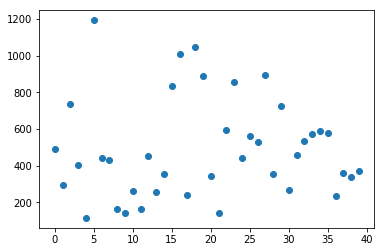

In [40]:
plt.scatter(range(0,len(val_img_subset.groupby('object_annotation_category')['object_id'].nunique().values)),val_img_subset.groupby('object_annotation_category')['object_id'].nunique().values)

Create a dictionary based on all the phytoplankton classes

In [41]:
class_id_list = [[x, i] for i, x in enumerate(list(sufficient_classes.index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

class_id_dict

{'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'bubble': 20,
 'centric': 21,
 'centric 1 temp': 22,
 'centric 2 temp': 23,
 'centric 3 temp': 24,
 'chain<centric': 25,
 'chain<pennate': 26,
 'detritus': 27,
 'dinoflagellate-i': 28,
 'dinoflagellate-ii': 29,
 'dinoflagellate-iii': 30,
 'pennate 1 temp': 31,
 'pennate 10 temp': 32,
 'pennate 11 temp': 33,
 'pennate 2 temp': 34,
 'pennate 7 temp': 35,
 't007': 36,
 't012': 37,
 't013': 38,
 'temp cylindrotheca': 39}

### Preprocess Images for Keras

Check for GPUs

In [42]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

Load all data into memory this should take ~4GB of RAM with ~20k samples

In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []
merged_labels = []
original_labels = []
flu_data = []
object_ids_training = []


for index, row in val_img_subset.iterrows():
#     to just interpolate it to 150x150 use these two lines of code
#     img = image.load_img('../../../Data/all_imagery/'+row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
#     images.append(image.img_to_array(img))
    
#     instead of interpolating increasing to max dimension and then padding
#     see https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055
#     based on https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    desired_size = 150
    im = cv2.imread('../../../Data/all_imagery/'+row['object_id']+'.png', cv2.IMREAD_GRAYSCALE)
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(im, 0, delta_h, 0, delta_w, cv2.BORDER_CONSTANT,0)
    img = new_im[..., np.newaxis]
    
    images.append(img)
    
    labels.append(class_id_dict[row['object_annotation_category']])
    original_labels.append(row['object_annotation_category'])
    flu_data.append(np.array(row[~val_img_subset.columns.isin(cols_not_for_training)].values, dtype=np.float32))
    object_ids_training.append(row['object_id'])
    
images = np.array(images)
labels = np.array(labels)
#merged_labels = np.array(merged_labels)
original_labels = np.array(original_labels)
flu_data = np.array(flu_data)
object_ids_training = np.array(object_ids_training)

Visualize an example of each class

(10, 150, 150)


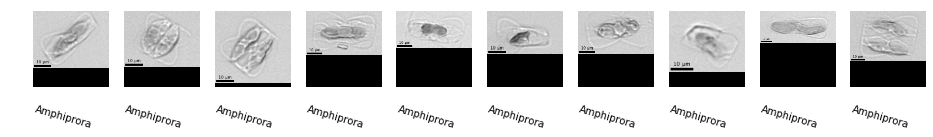

(10, 150, 150)


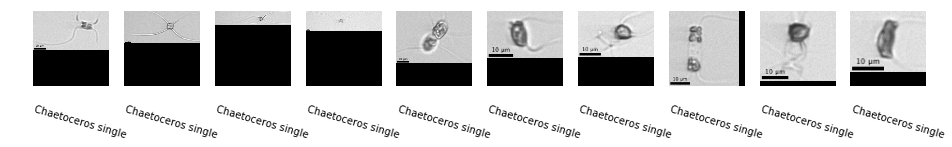

(10, 150, 150)


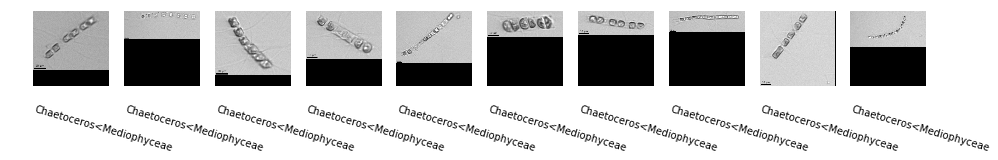

(10, 150, 150)


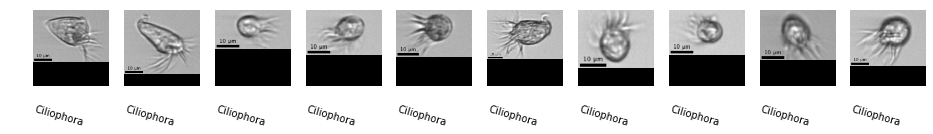

(10, 150, 150)


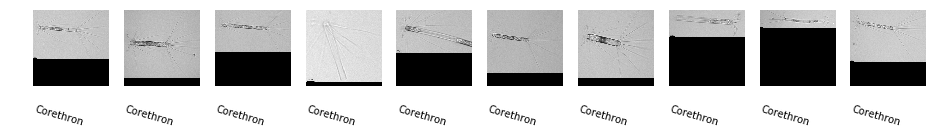

(10, 150, 150)


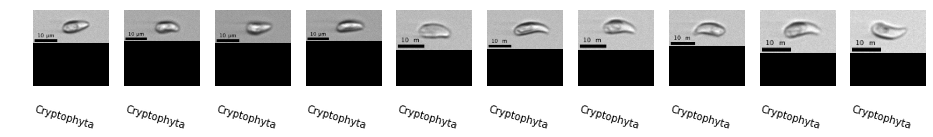

(10, 150, 150)


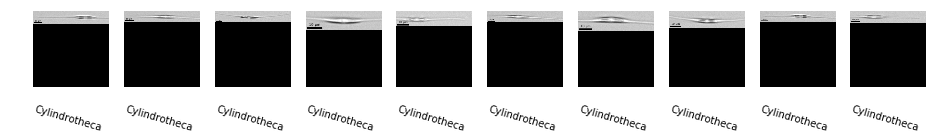

(10, 150, 150)


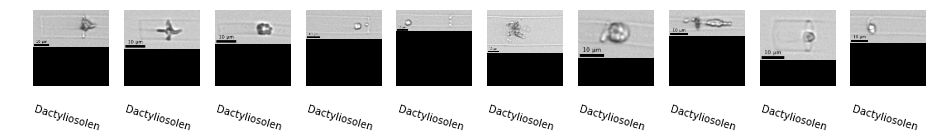

(10, 150, 150)


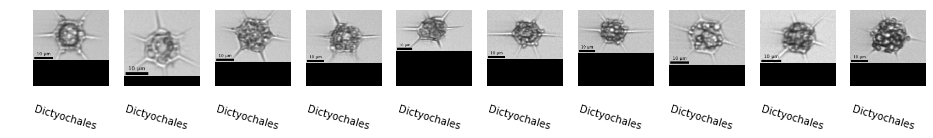

(10, 150, 150)


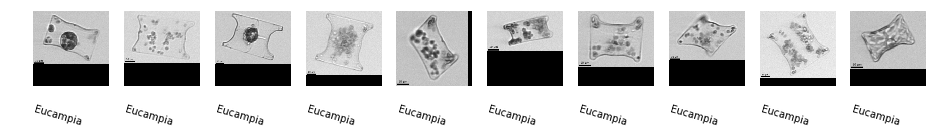

(10, 150, 150)


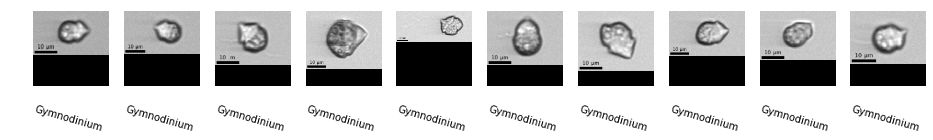

(10, 150, 150)


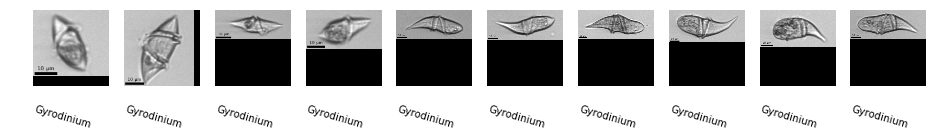

(10, 150, 150)


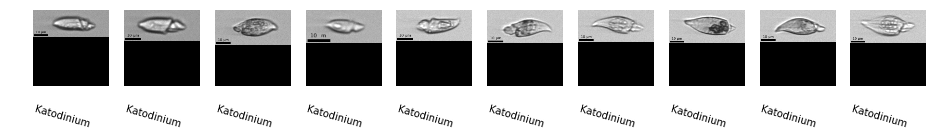

(10, 150, 150)


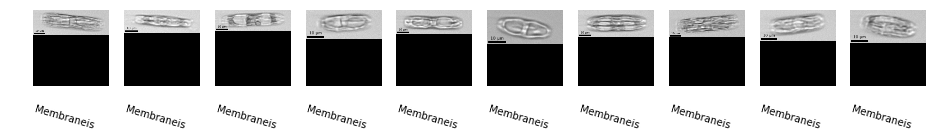

(10, 150, 150)


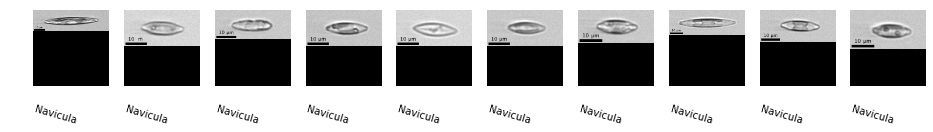

(10, 150, 150)


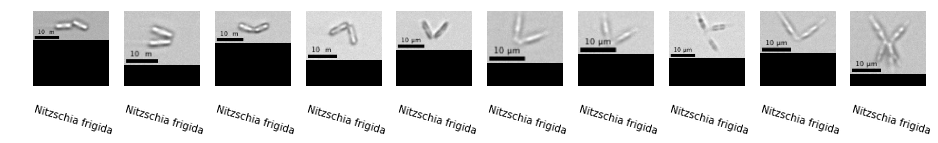

(10, 150, 150)


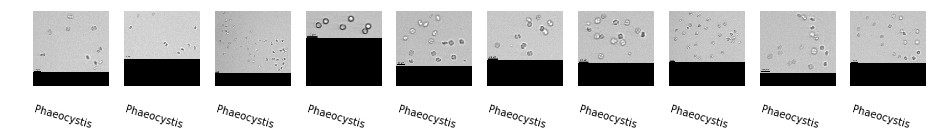

(10, 150, 150)


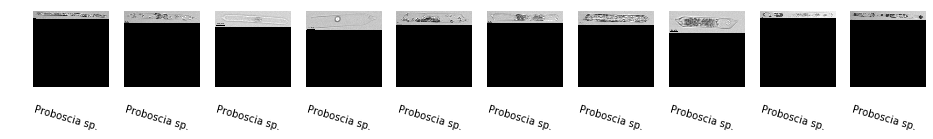

(10, 150, 150)


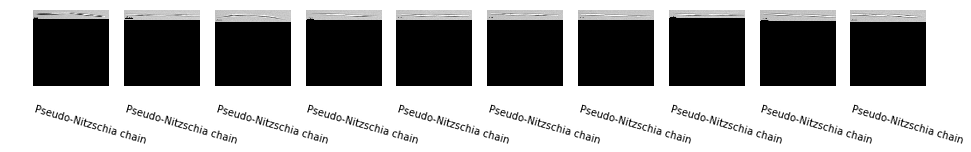

(10, 150, 150)


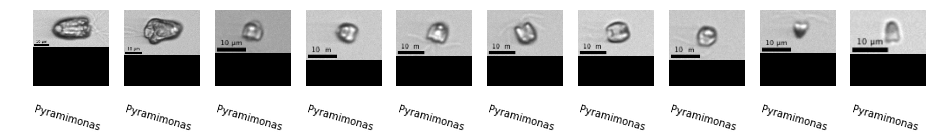

(10, 150, 150)


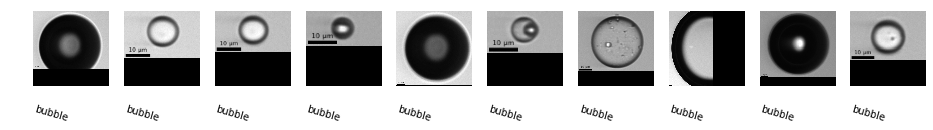

(10, 150, 150)


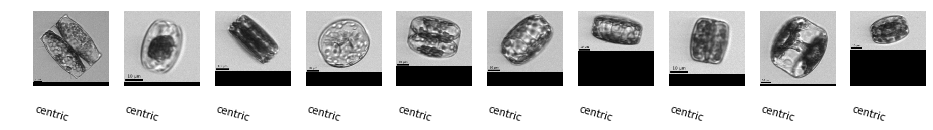

(10, 150, 150)


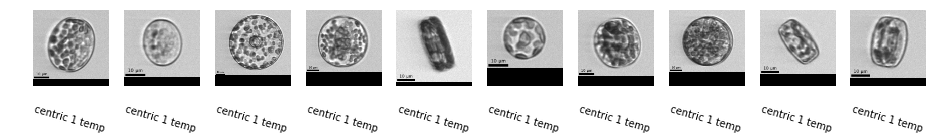

(10, 150, 150)


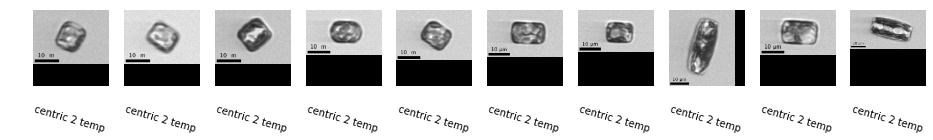

(10, 150, 150)


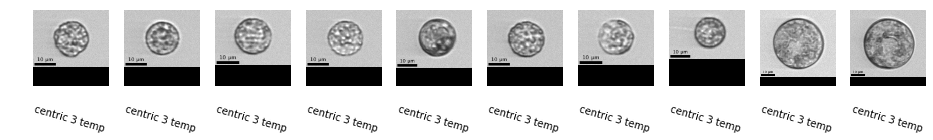

(10, 150, 150)


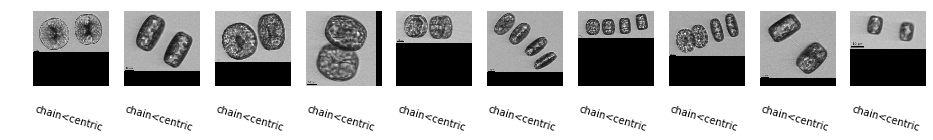

(10, 150, 150)


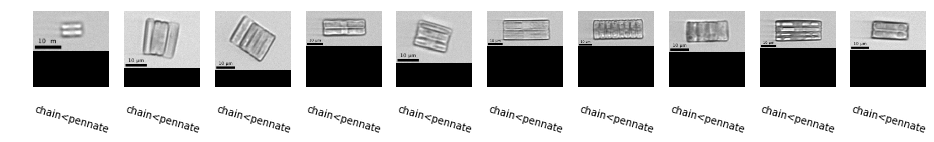

(10, 150, 150)


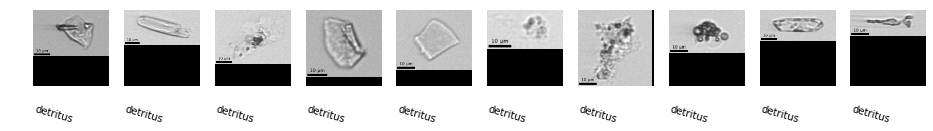

(10, 150, 150)


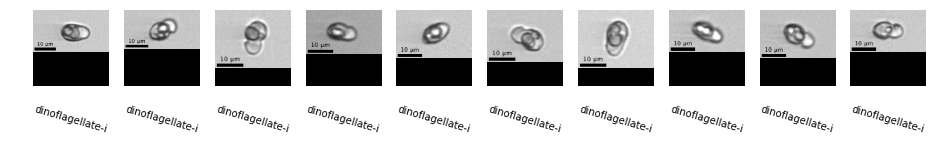

(10, 150, 150)


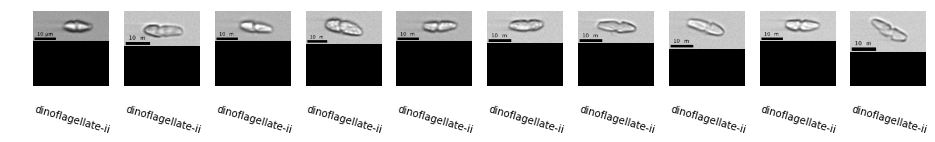

(10, 150, 150)


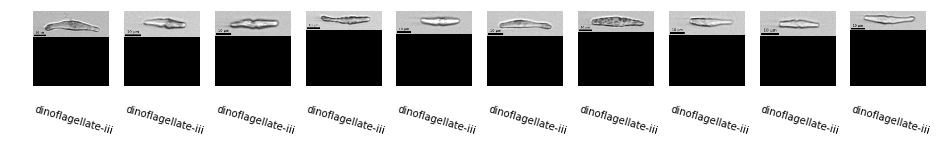

(10, 150, 150)


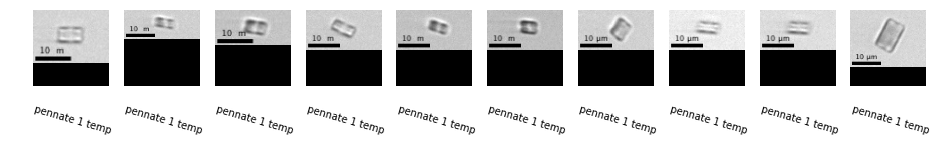

(10, 150, 150)


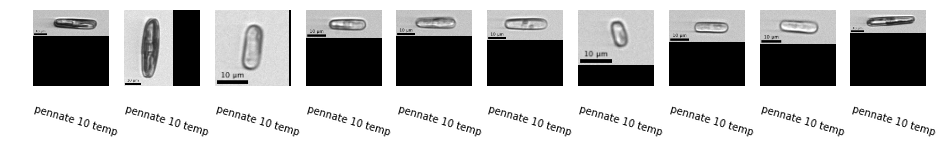

(10, 150, 150)


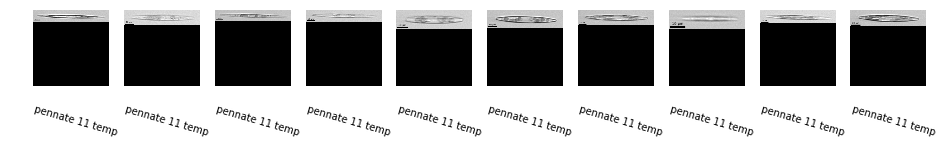

(10, 150, 150)


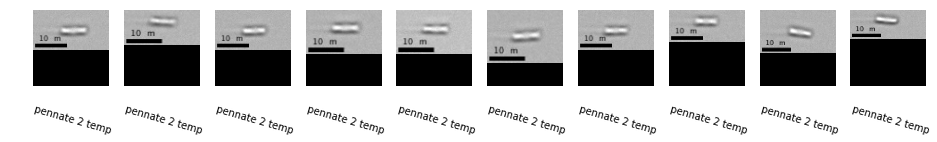

(10, 150, 150)


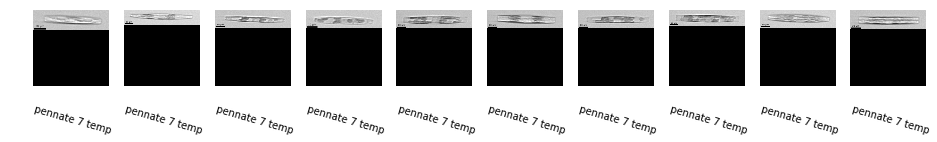

(10, 150, 150)


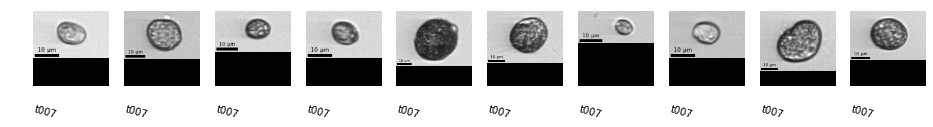

(10, 150, 150)


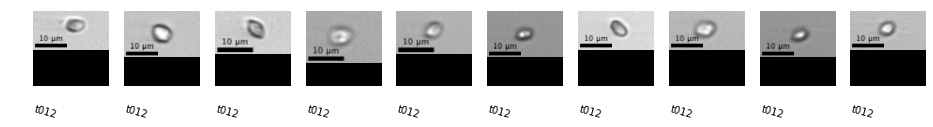

(10, 150, 150)


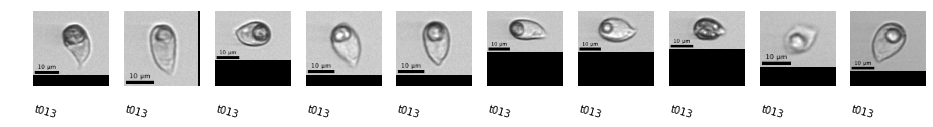

(10, 150, 150)


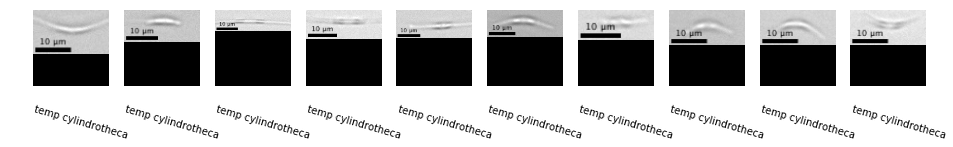

In [44]:
for i in range(np.max(labels)+1):
    imgs_display = images[labels == i][:10,:,:,0]
    print(imgs_display.shape)
    #mlabs = merged_labels[labels == i][:10]
    olabs = original_labels[labels == i][:10]
    fig, ax = plt.subplots(1, 10, figsize=(16, 3))
    for j in range(0, 10):
        try:
            ax[j].imshow(imgs_display[j], cmap = 'gray')
            ax[j].axis('off')
            #ax[j].text(0,-10, mlabs[j], rotation=16)
            ax[j].text(0,200, olabs[j],rotation=-16)
        except IndexError:
            continue
    plt.show()

What are the shapes of the images, labels, and handcrafted features

In [45]:
images.shape, labels.shape, flu_data.shape, object_ids_training.shape

((19684, 150, 150, 1), (19684,), (19684, 233), (19684,))

This is for running a random forest model but is all commented out now

In [46]:
# # for Random Forest
# images = images[~np.any(np.isnan(flu_data), axis=1)]
# original_labels = original_labels[~np.any(np.isnan(flu_data), axis=1)]

# labels = labels[~np.any(np.isnan(flu_data), axis=1)]
# object_ids_training = object_ids_training[~np.any(np.isnan(flu_data), axis=1)]
# flu_data = flu_data[~np.any(np.isnan(flu_data), axis=1)]

Are there any nonzero features? This can throw an error in the model.

In [47]:
np.count_nonzero(np.isnan(flu_data), axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Don't need to run this anymore since we removed all the nan data BUT if there is a nan in any column above you can replace it with zero via this line

In [48]:
# flu_data[np.isnan(flu_data)] = 0

Split the data into train and test via sklearn function

Also  change the labels to one hot encoding which keras needs

In [49]:
from tensorflow import keras

from sklearn.model_selection import train_test_split

num_classes = len(class_id_dict)

test_size = 0.20

X_train, X_test, flu_train, flu_test, ids_train, ids_test, y_train, y_test = train_test_split(images, flu_data, object_ids_training, labels, test_size=test_size, random_state=42, stratify=labels)
#flu_train, flu_test, ids_train, ids_test, y_train, y_test = train_test_split(flu_data, object_ids_training, labels, test_size=test_size, random_state=42, stratify=labels)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train.shape, flu_train.shape, X_test.shape

((15747, 150, 150, 1), (15747, 233), (3937, 150, 150, 1))

### Augment both the images and the features

Images are augmented via a rotations, flips, gaussian noise, and contrast changes while features are randomly multiplied by a factor between .8 and 1.2

Quickly see how imbalanced the data is:

In [50]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 490,  295,  739,  405,  116, 1193,  443,  429,  167,  141,  263,
         166,  454,  256,  353,  834, 1010,  243, 1045,  887,  346,  142,
         595,  859,  444,  562,  531,  896,  353,  724,  270,  457,  534,
         571,  591,  579,  234,  358,  340,  369]))

Augmentation function

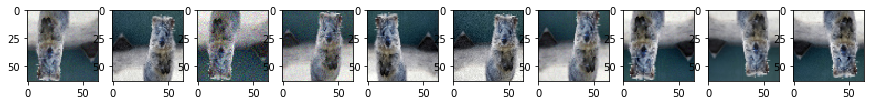

In [51]:
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images_example = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5),
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.1,
        iaa.GaussianBlur(sigma=(0, 0.2))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.9, 1.1)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    #iaa.Affine(
    #    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    #    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    #    rotate=(-25, 25),
    #    shear=(-8, 8)
    #)
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images_example)
fig, ax = plt.subplots(1,10, figsize=(15,10))
for i in range(10):
    ax[i].imshow(images_aug[i])


See what the augmentations look like

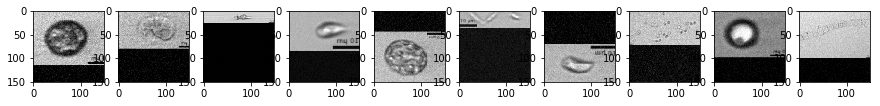

In [52]:
images_aug = seq(images=X_train[:20])
fig, ax = plt.subplots(1,10, figsize=(15,10))
for i in range(10):
    ax[i].imshow(images_aug[i,:,:,0], cmap = 'gray')

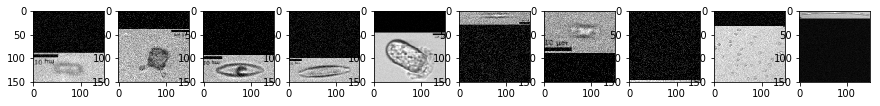

In [53]:
images_aug = seq(images=X_train[1000:1020])
fig, ax = plt.subplots(1,10, figsize=(15,10))
for i in range(10):
    ax[i].imshow(images_aug[i,:,:,0], cmap = 'gray')

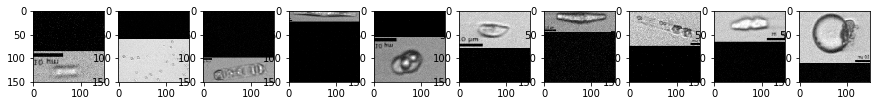

In [54]:
images_aug = seq(images=X_train[5000:5020])
fig, ax = plt.subplots(1,10, figsize=(15,10))
for i in range(10):
    ax[i].imshow(images_aug[i,:,:,0], cmap = 'gray')

Apply the augmentations so that we have `max_count` of each class either from real data or from real+augmentations

In [55]:
import random

y_train_argmax = np.argmax(y_train, axis=1)

#train_count = int((1-test_size) * max_count)
max_count = 1000
train_count = max_count

# take the image and augment it and add it to a stack and add the label to another stack and the concat them to the main stacks
class_labels, count_of_classes = np.unique(y_train_argmax, return_counts=True)
list_of_all_images = []
list_of_all_flu_data = []
list_of_all_labs = []
for l, c in enumerate(count_of_classes):
    #print(l)
    list_of_class_images = []
    list_of_class_labs = []
    list_of_class_flu_data = []
    if c < train_count:
        num_to_aug = train_count - c
        all_im_of_class = X_train[y_train_argmax == l]
        all_flu_of_class = flu_train[y_train_argmax == l]
        for i in range(0,num_to_aug):
            im_idx = random.randint(0, all_im_of_class.shape[0]-1)
            im = all_im_of_class[im_idx,:,:,:]
            flu = all_flu_of_class[im_idx,:]
            im = seq(image=im)
            # augmenting the flu data but not sure this is ideal
            flu = flu*random.uniform(0.8, 1.2)
            list_of_class_images.append(im)
            list_of_class_labs.append(l)
            list_of_class_flu_data.append(flu)
    list_of_all_images = list_of_all_images + list_of_class_images
    list_of_all_labs = list_of_all_labs + list_of_class_labs
    list_of_all_flu_data = list_of_all_flu_data + list_of_class_flu_data

Change the labels to a one hot encoding

In [56]:
one_hot = keras.utils.to_categorical(np.array(list_of_all_labs), num_classes)
y_train.shape, one_hot.shape

((15747, 40), (24253, 40))

add this new augmented data into the training data

In [57]:
X_train = np.concatenate((X_train, np.array(list_of_all_images)), axis=0)
list_of_all_flu_data = np.array(list_of_all_flu_data)
flu_train = np.concatenate((flu_train, list_of_all_flu_data), axis=0)

y_train = np.concatenate((y_train, one_hot))

In [58]:
X_train.shape, flu_train.shape, y_train.shape

((40000, 150, 150, 1), (40000, 233), (40000, 40))

How large is X_train in GB

In [59]:
import sys

sys.getsizeof(X_train) / 1e9

0.900000144

### Must normalize the data or training results are erratic and slow!

First scale the train and test handcrafted features using sklearn's Scaler

Inspect the mean and std distributions pre scaling

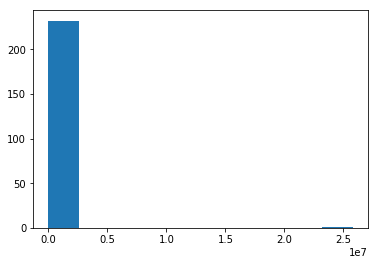

In [60]:
plt.hist(np.mean(flu_test, axis=0))
plt.show()

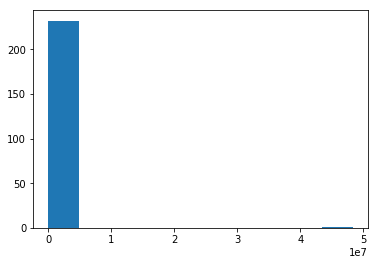

In [61]:
plt.hist(np.std(flu_test, axis=0))
plt.show()

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(flu_train)
flu_train = scaler.transform(flu_train)
flu_test = scaler.transform(flu_test)

save the scaler for later use when predicting on larger datasets

In [63]:
import joblib
joblib.dump(scaler, output_scaler_fp)

['scaler_feats_230221_1.gz']

Inspect the mean and std distributions post scaling

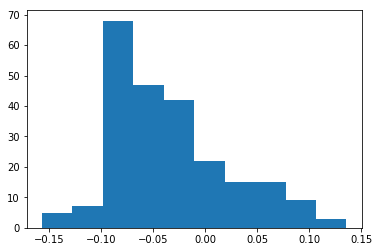

In [64]:
plt.hist(np.mean(flu_test, axis=0))
plt.show()

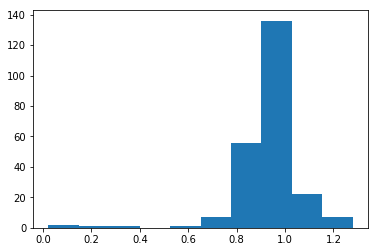

In [65]:
plt.hist(np.std(flu_test, axis=0))
plt.show()

Now scale the imagery by dividing by 255

In [66]:
np.mean(X_train), np.std(X_train), np.mean(X_test), np.std(X_test)

(69.40011168, 69.98060963802753, 66.4009219766884, 71.70203644457003)

In [67]:
np.max(X_test)

255

In [68]:
X_train = X_train / 255
X_test = X_test / 255

np.mean(X_train), np.std(X_train), np.mean(X_test), np.std(X_test)

(0.27215730070588123,
 0.2744337632863996,
 0.2603957724576026,
 0.28118445664536734)

In [69]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1.], dtype=float32), array([1560000,   40000])),
 (array([0., 1.], dtype=float32), array([153543,   3937])))

#### shuffle input data

In [70]:
from sklearn.utils import shuffle
X_train, flu_train, y_train = shuffle(X_train, flu_train, y_train)

Commented out now but code to Train RF Model

In [71]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# clf = RandomForestClassifier()
# clf.fit(flu_train, y_train)

## Run the Model

Set of some training hyperparameters

In [72]:
input_shape = X_train.shape[1:]
flu_input_shape = flu_train.shape[1:]
batch_size = 40

epochs = 30

input_shape, flu_input_shape

((150, 150, 1), (233,))

In [73]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

### Medium Complexity Model

After many different models this one seems to be the best. A relatively simple CNN that takes in the images and concats them with all the features.

In [74]:
inputs = Input(shape=input_shape)
input_flu = Input(shape=flu_input_shape)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# switch to functional and concat the other features here before the dense layer

x = Flatten()(x)
x = Concatenate(axis=-1)([x, input_flu])
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model([inputs,input_flu], output)
#model = Model([inputs], output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 148, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 74, 74, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout (D

The classes should be balanced for now but if we want to emphasize one class or if they're imbalanced on training this will correct for that.

In [75]:
from sklearn.utils import class_weight

weights_for_unaug = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
weights_for_unaug

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [76]:
checkpoint = ModelCheckpoint(model_save_fp, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adadelta(),
          metrics=['accuracy'])

history = model.fit(x=[X_train, flu_train], y=y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([X_test,flu_test], y_test),
                    callbacks=callbacks_list,
                    class_weight=weights_for_unaug)

Train on 40000 samples, validate on 3937 samples
Epoch 1/30
39960/40000 [============================>.] - ETA: 0s - loss: 0.8847 - acc: 0.7316
Epoch 00001: val_acc improved from -inf to 0.87224, saving model to ../model_weights_230221_1.hdf5
40000/40000 [==============================] - 49s 1ms/step - loss: 0.8840 - acc: 0.7318 - val_loss: 0.4369 - val_acc: 0.8722
Epoch 2/30
39960/40000 [============================>.] - ETA: 0s - loss: 0.4520 - acc: 0.8602
Epoch 00002: val_acc improved from 0.87224 to 0.90145, saving model to ../model_weights_230221_1.hdf5
40000/40000 [==============================] - 46s 1ms/step - loss: 0.4520 - acc: 0.8601 - val_loss: 0.3395 - val_acc: 0.9014
Epoch 3/30
39960/40000 [============================>.] - ETA: 0s - loss: 0.3549 - acc: 0.8903
Epoch 00003: val_acc improved from 0.90145 to 0.91161, saving model to ../model_weights_230221_1.hdf5
40000/40000 [==============================] - 47s 1ms/step - loss: 0.3551 - acc: 0.8903 - val_loss: 0.3222 - v

39960/40000 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9682
Epoch 00029: val_acc did not improve from 0.93472
40000/40000 [==============================] - 47s 1ms/step - loss: 0.1126 - acc: 0.9682 - val_loss: 0.3785 - val_acc: 0.9309
Epoch 30/30
39960/40000 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9709
Epoch 00030: val_acc did not improve from 0.93472
40000/40000 [==============================] - 46s 1ms/step - loss: 0.1041 - acc: 0.9709 - val_loss: 0.4087 - val_acc: 0.9299


dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


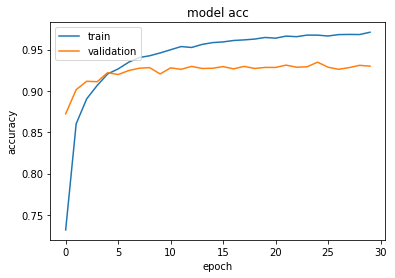

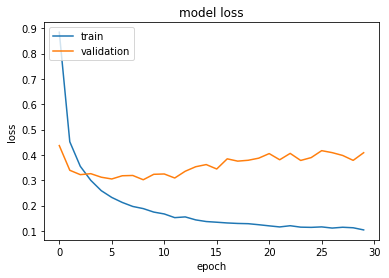

In [77]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#experiment.log_figure(figure=plt, figure_name="model_acc")
plt.savefig("../modelacc.png", dpi=300)
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#experiment.log_figure(figure=plt, figure_name="model_loss")
plt.savefig("../modelloss.png", dpi=300)
plt.show()

### Assess the model recall, precision, accuracy

In [78]:
from tensorflow import keras

model = keras.models.load_model(model_save_fp)

Early glimpse of a couple images

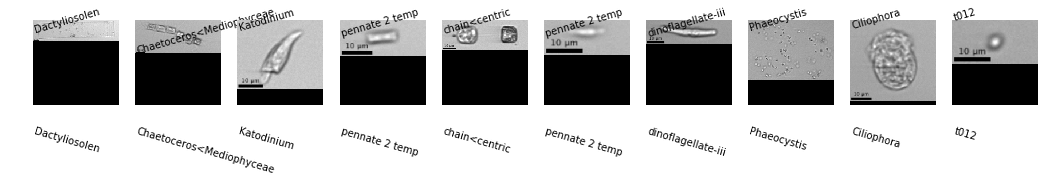

In [79]:
fig, ax = plt.subplots(1, 10, figsize=(18, 10))

indices = np.random.randint(len(X_test), size=(10))
predictions = np.argmax(model.predict([X_test[indices], flu_test[indices]]), axis=1)
#predictions = np.argmax(model.predict([X_test[indices]]), axis=1)
labs = np.argmax(y_test[indices], axis=1)

for i in range(0, 10):
    ax[i].imshow(X_test[indices[i]].reshape((150, 150)), cmap = 'gray')
    ax[i].axis('off')
    ax[i].text(0,-10, id_class_dict[labs[i]], rotation=16)
    
    ax[i].text(0,200, id_class_dict[predictions[i]],rotation=-16)
plt.show()

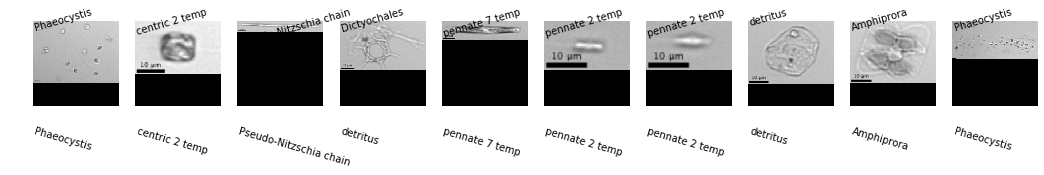

In [80]:
fig, ax = plt.subplots(1, 10, figsize=(18, 10))

indices = np.random.randint(len(X_test), size=(10))
predictions = np.argmax(model.predict([X_test[indices], flu_test[indices]]), axis=1)
#predictions = np.argmax(model.predict([X_test[indices]]), axis=1)
labs = np.argmax(y_test[indices], axis=1)

for i in range(0, 10):
    ax[i].imshow(X_test[indices[i]].reshape((150, 150)), cmap = 'gray')
    ax[i].axis('off')
    ax[i].text(0,-10, id_class_dict[labs[i]], rotation=16)
    
    ax[i].text(0,200, id_class_dict[predictions[i]],rotation=-16)
plt.show()

### running this evaluation on val data and not including train

these next few code blocks pull out only validation data

In [81]:
len(val_img_subset)

19684

In [82]:
val_img_subset = val_img_subset.reset_index()

In [83]:
val_img_subset = val_img_subset.set_index('object_id')
#img_md_subset.update(new_val.set_index('object_id')[['object_annotation_status', 'object_annotation_category']])
# this is effectively an upsert operation like in SQL
val_img_subset_only_test = val_img_subset[val_img_subset.index.isin(ids_test)]
val_img_subset_only_test = val_img_subset_only_test.reset_index()
val_img_subset = val_img_subset.reset_index()

In [84]:
#val_img_subset_only_test = val_img_subset

In [85]:
len(val_img_subset_only_test)

3937

How many in each class in this val data?

In [86]:
val_img_subset_only_test.groupby('object_annotation_category')['object_id'].nunique()

object_annotation_category
Amphiprora                   98
Chaetoceros single           59
Chaetoceros<Mediophyceae    148
Ciliophora                   81
Corethron                    23
Cryptophyta                 239
Cylindrotheca                89
Dactyliosolen                86
Dictyochales                 33
Eucampia                     28
Gymnodinium                  53
Gyrodinium                   33
Katodinium                   91
Membraneis                   51
Navicula                     71
Nitzschia frigida           167
Phaeocystis                 202
Proboscia sp.                48
Pseudo-Nitzschia chain      209
Pyramimonas                 177
bubble                       69
centric                      28
centric 1 temp              119
centric 2 temp              172
centric 3 temp               89
chain<centric               112
chain<pennate               106
detritus                    179
dinoflagellate-i             71
dinoflagellate-ii           145
dinoflagellat

Load all val data into memory to use it for eval

In [87]:
from tensorflow.keras.preprocessing import image
import numpy as np

names = []
accs = []
counts = []
all_labs = []
all_preds = []

for name, group in val_img_subset_only_test.groupby('object_annotation_category')['object_id']:
    #print('*** ',name)    
    images = []
    labels = []
    flus = []

    for fn in group:

        # TODO need to think about optimal size and that size actually corresponds to class
        # maybe add blackspace instead of interpolating because it is changing the morphology

#         img = image.load_img('../../../Data/all_imagery/'+fn+'.png', target_size=(150, 150), color_mode="grayscale")
#         images.append(image.img_to_array(img))
        
#         instead of interpolating increasing to max dimension and then padding
#         see https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055
#         based on https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
        desired_size = 150
        im = cv2.imread('../../../Data/all_imagery/'+fn+'.png', cv2.IMREAD_GRAYSCALE)
        old_size = im.shape[:2] # old_size is in (height, width) format
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        # new_size should be in (width, height) format
        im = cv2.resize(im, (new_size[1], new_size[0]))
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        new_im = cv2.copyMakeBorder(im, 0, delta_h, 0, delta_w, cv2.BORDER_CONSTANT,0)
        img = new_im[..., np.newaxis]
        images.append(img)
    
        mc = val_img_subset[val_img_subset.object_id == fn].object_annotation_category
        labels.append(class_id_dict[mc.values[0]])
        flus.append(np.array(val_img_subset[val_img_subset.object_id == fn].iloc[0][~val_img_subset.columns.isin(cols_not_for_training)].values, dtype=np.float32))
        
    images = np.array(images)
    labels = np.array(labels)
    flus = np.array(flus)
    #print(flus.shape)
    flus = scaler.transform(flus)
    X_predict = images / 255
    
    predictions = np.argmax(model.predict([X_predict, flus]), axis=1)
    names.append(name)
    accs.append(np.count_nonzero(labels==predictions)/len(labels))
    counts.append(len(labels))
    all_labs += list(labels)
    all_preds += list(predictions)
    
    


### Evaluate RF Model

In [88]:
#val_img_subset_only_test = val_img_subset_only_test.drop(val_img_subset_only_test[val_img_subset_only_test.object_annotation_category.isin(['Unknowns'])].index)

In [89]:
# flu_data = []
# labels = []
# for index, row in val_img_subset_only_test.iterrows():
#     flu_data.append(np.array(row[~val_img_subset_only_test.columns.isin(cols_not_for_training)].values, dtype=np.float32))
#     labels.append(class_id_dict[row['object_annotation_category']])

In [90]:
#val_img_subset_only_test

In [91]:
# flu_data = np.array(flu_data)
# labels = np.array(labels)

# labels = labels[~np.any(np.isnan(flu_data), axis=1)]
# flu_data = flu_data[~np.any(np.isnan(flu_data), axis=1)]

In [92]:
# all_labs = clf.predict(np.array(flu_data))
# all_preds = np.array(labels)

In [93]:
classes, counts = np.unique(all_preds, return_counts=True)
true_classes, true_counts = np.unique(all_labs, return_counts=True)

In [94]:
classes, counts = np.unique(all_preds, return_counts=True)
print(len(counts))

40


If any classes didn't get predicted or weren't in the data this fills in zeros for them so these eval metrics work

In [95]:
classes, counts = np.unique(all_preds, return_counts=True)
true_classes, true_counts = np.unique(all_labs, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if i >= len(classes):
        filled_counts.append(0)
        prev_class += 1
    elif classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if i >= len(true_classes):
        filled_true_counts.append(0)
        prev_class += 1
    elif true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

What was precision/recall/f1???

In [96]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), average='weighted', labels=list(id_class_dict.keys()))

(0.935746573909003, 0.9347218694437389, 0.9345649793739542, None)

#### Create the main assessment figs

In [97]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), 
                                average=None, labels=list(id_class_dict.keys()))

In [98]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

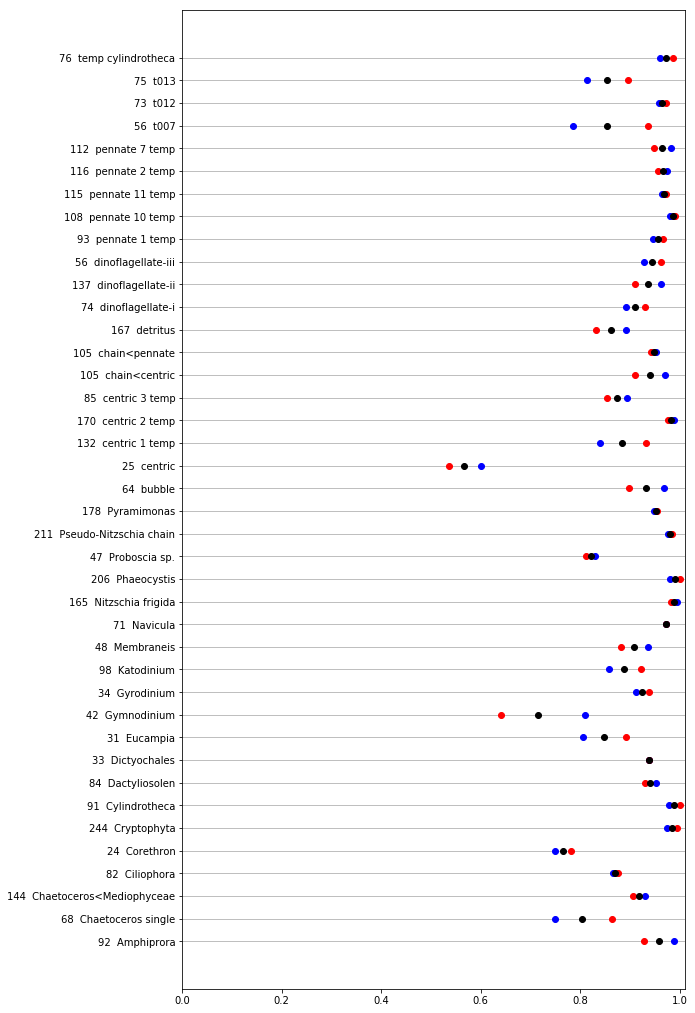

In [99]:
nc = [str(n) + '  ' + m for m,n in zip(names,counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('../individual_class_acc_densenet_model.png', dpi=300)
plt.show()

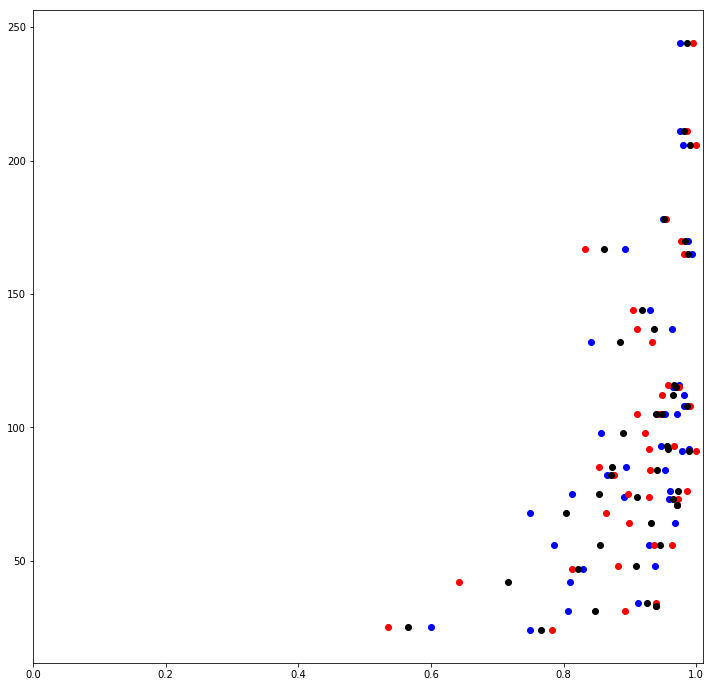

In [100]:
nc = [str(n) + '  ' + m for m,n in zip(names,counts)]

fig, ax = plt.subplots(figsize=(12, 12))
#ax.scatter(accs, counts)
ax.scatter(precision, counts, color='blue')
ax.scatter(recall, counts, color='red')
ax.scatter(fscore, counts, color='black')
#ax.set_yticks(range(0,len(names)))
#ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')
#ax.set_ylim(-10,1500)

# Don't allow the axis to be on top of your data
#ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
#ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('count_vs_acc.png', dpi=300)
plt.show()

Text(0.5, 331.09999999999985, 'Predicted label')

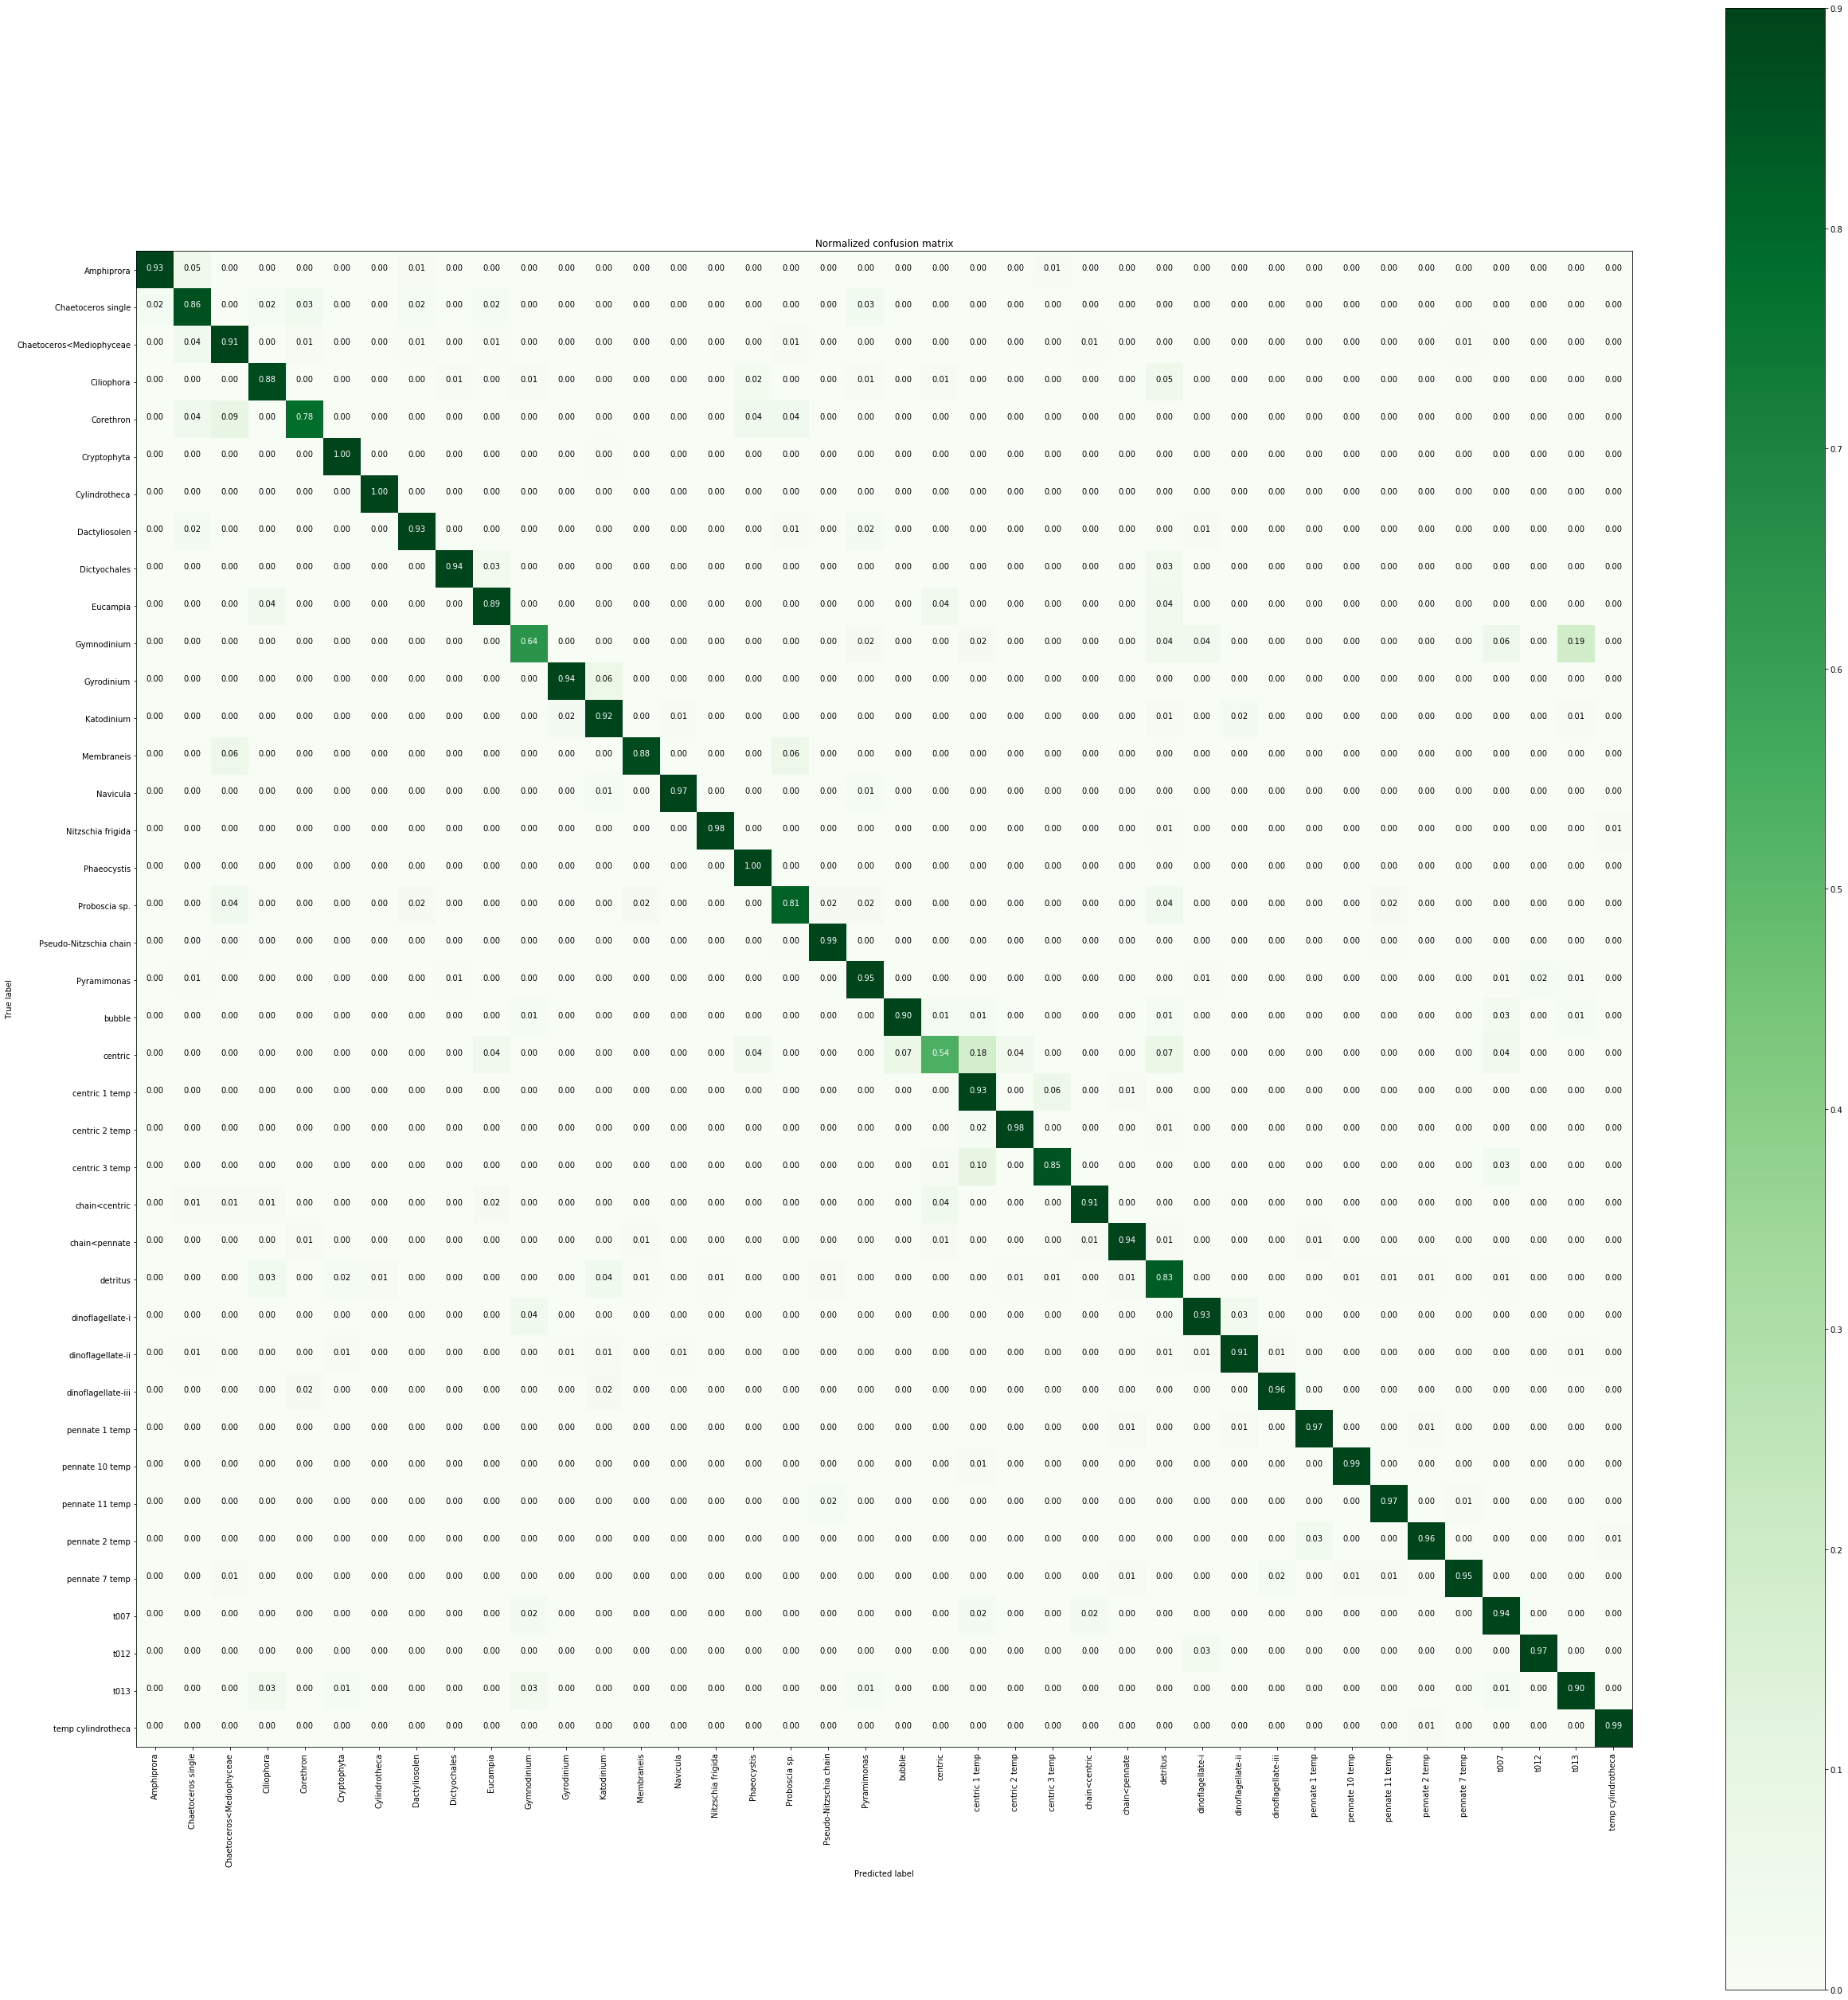

In [101]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(all_labs), np.array(all_preds))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(35,35)) 

plt.imshow(cm, cmap = 'Greens', vmax=0.9)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))], rotation=90)
plt.yticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))])

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_unmerged_visible_low_end_large.png', dpi=300)

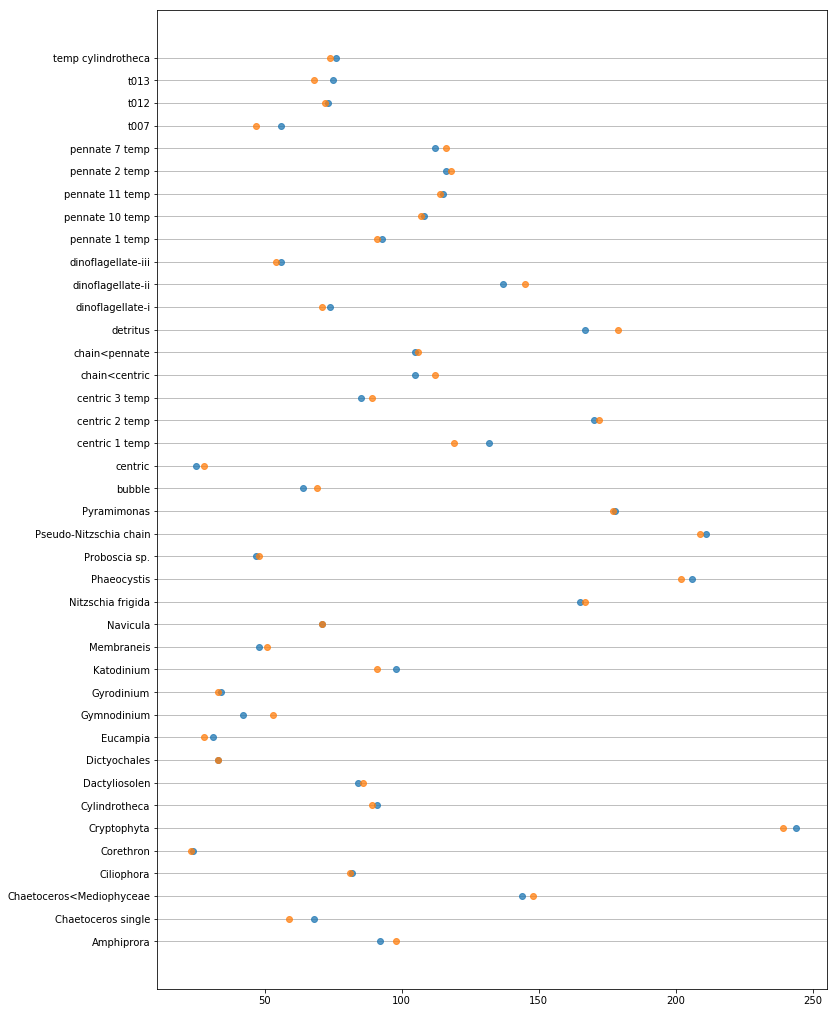

In [102]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(0,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Evaluate the merged classes

Starting with the medium merged labels

In [105]:
# Diatoms: 

## Pennate Diatoms:
amphiprora = ['Amphiprora']                    
cylindrotheca = ['Cylindrotheca']                 
nitzschia_frigida = ['Nitzschia frigida']             
pseudo_nitzschia_chain = ['Pseudo-Nitzschia chain'] 

unidentified_single_pennate = [
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
]

## Centric Diatoms
chaetoceros_mediophyceae = ['Chaetoceros<Mediophyceae']
chaetoceros_single = ['Chaetoceros single']
corethron = ['Corethron']
eucampia = ['Eucampia']
dactyliosolen = ['Dactyliosolen']
proboscia = ['Proboscia sp.']
unidentified_single_centric = [
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

# Dinoflagellates: 
gyrodinium = ['Gyrodinium']
gymnodinium = ['Gymnodinium'] 
katodinium = ['Katodinium']
dinoflagellate_i = ['dinoflagellate-i']
dinoflagellate_ii = ['dinoflagellate-ii']
dinoflagellate_iii = ['dinoflagellate-iii']

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']

unidentified_flagellates = [ 
    't007',
    't012',
    't013',
]

other = [ 
    'bubble',
    'detritus',
]

This is the final list of classes in the current iteration

In [173]:
class_id_list = [[x, i] for i, x in enumerate(list(sufficient_classes.index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

In [174]:
all_classes = list(class_id_dict)

Ensure there are the same number in each set

In [175]:
all_classes_sep = amphiprora+cylindrotheca+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia+dactyliosolen +proboscia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+pyramimonas +phaeocystis+dictyochales +ciliophora+unidentified_flagellates+other
len(all_classes), len(all_classes_sep)

(40, 40)

In [109]:
list(set(all_classes) - set(all_classes_sep))

[]

In [110]:
list(set(all_classes_sep) - set(all_classes))

[]

In [111]:
class_str = 'amphiprora+cylindrotheca+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia+dactyliosolen +proboscia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+pyramimonas +phaeocystis+dictyochales +ciliophora +unidentified_flagellates+other'
class_str.replace('+', ',')

'amphiprora,cylindrotheca,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia,dactyliosolen ,proboscia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,unidentified_flagellates,other'

In [112]:
class_str.replace('+', "','")

"amphiprora','cylindrotheca','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia','dactyliosolen ','proboscia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','unidentified_flagellates','other"

#### adding all the merged classes into the dataframe

This block is what actually adds the merged categories into the dataframe

In [113]:
classes = [amphiprora,cylindrotheca,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia,dactyliosolen ,proboscia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,unidentified_flagellates,other]

class_names = ['amphiprora','cylindrotheca','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia','dactyliosolen ','proboscia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','unidentified_flagellates','other']

img_md_subset["merged_category"] = ""
for i in range(len(classes)):
    img_md_subset['merged_category'][img_md_subset['object_annotation_category'].isin(classes[i])] = class_names[i]

Find the merged class name corresponding to the individual class name it was classified into

In [114]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [115]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])


In [116]:
len(all_labs), len(merged_labs_truth), len(merged_labs)

(3937, 3937, 3937)

In [117]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'amphiprora',
 1: 'cylindrotheca',
 2: 'nitzschia_frigida',
 3: 'pseudo_nitzschia_chain',
 4: 'unidentified_single_pennate',
 5: 'chaetoceros_mediophyceae',
 6: 'chaetoceros_single',
 7: 'corethron',
 8: 'eucampia',
 9: 'dactyliosolen ',
 10: 'proboscia ',
 11: 'unidentified_single_centric',
 12: 'cryptophyta',
 13: 'gyrodinium',
 14: 'gymnodinium',
 15: 'katodinium',
 16: 'dinoflagellate_i',
 17: 'dinoflagellate_ii ',
 18: 'dinoflagellate_iii',
 19: 'pyramimonas ',
 20: 'phaeocystis',
 21: 'dictyochales ',
 22: 'ciliophora ',
 23: 'unidentified_flagellates',
 24: 'other'}

In [118]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

(3937, 3937)

In [119]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

(3937, 3937)

In [120]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

(0.9473933708482004, 0.9466598933197866, 0.9465426807375501, None)

In [121]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [122]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

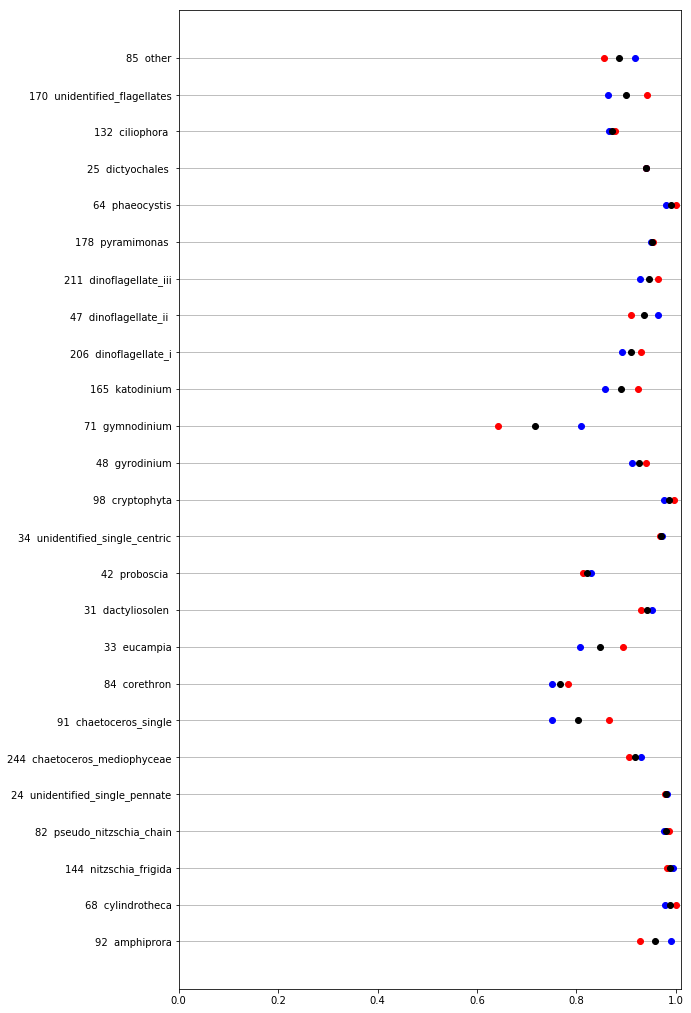

In [123]:
nc = [str(n) + '  ' + m for m,n in zip(names,counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

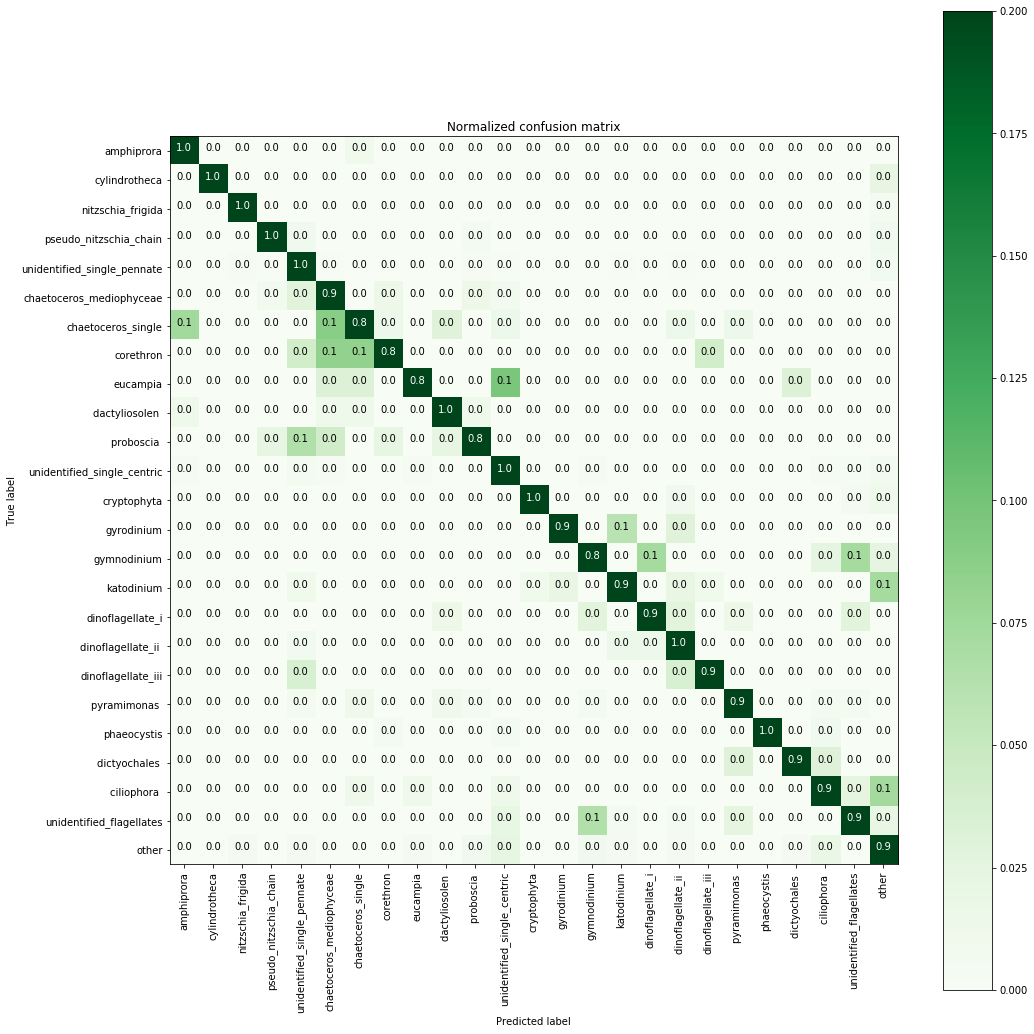

In [124]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))], rotation=90)
plt.yticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))])

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_medium_merged.png', dpi=300)

Now the most merged labels

In [134]:
# Diatoms: 


## Pennate Diatoms:
pennates = [
    'Amphiprora',                    
    'Cylindrotheca'  ,             
    'Nitzschia frigida'  ,        
    'Pseudo-Nitzschia chain',
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
]

## Centric Diatoms
centrics = [
    'Chaetoceros<Mediophyceae',
    'Chaetoceros single',
    'Corethron',
    'Eucampia',
    'Dactyliosolen',
    'Proboscia sp.',
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

dinoflagellates = [
    'Gyrodinium',
    'Gymnodinium',
    'Katodinium',
    'dinoflagellate-i',
    'dinoflagellate-ii',
    'dinoflagellate-iii',
]

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']

unidentified_flagellates = [ 
    't007',
    't012',
    't013',
]

other = [ 
    'bubble',
    'detritus',
]

In [176]:
class_id_list = [[x, i] for i, x in enumerate(list(sufficient_classes.index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

In [177]:
all_classes_sep = pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+unidentified_flagellates+other
len(all_classes), len(all_classes_sep)

(40, 40)

In [178]:
list(set(all_classes) - set(all_classes_sep))

[]

In [179]:
list(set(all_classes_sep) - set(all_classes))

[]

In [180]:
class_str = 'pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+unidentified_flagellates+other'
class_str.replace('+', ',')

'pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,unidentified_flagellates,other'

In [181]:
class_str.replace('+', "','")

"pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','unidentified_flagellates','other"

adding all the merged classes into the dataframe

In [182]:
classes = [pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,unidentified_flagellates,other]

class_names = ['pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','unidentified_flagellates','other']

In [183]:
id_class_dict

{0: 'Amphiprora',
 1: 'Chaetoceros single',
 2: 'Chaetoceros<Mediophyceae',
 3: 'Ciliophora',
 4: 'Corethron',
 5: 'Cryptophyta',
 6: 'Cylindrotheca',
 7: 'Dactyliosolen',
 8: 'Dictyochales',
 9: 'Eucampia',
 10: 'Gymnodinium',
 11: 'Gyrodinium',
 12: 'Katodinium',
 13: 'Membraneis',
 14: 'Navicula',
 15: 'Nitzschia frigida',
 16: 'Phaeocystis',
 17: 'Proboscia sp.',
 18: 'Pseudo-Nitzschia chain',
 19: 'Pyramimonas',
 20: 'bubble',
 21: 'centric',
 22: 'centric 1 temp',
 23: 'centric 2 temp',
 24: 'centric 3 temp',
 25: 'chain<centric',
 26: 'chain<pennate',
 27: 'detritus',
 28: 'dinoflagellate-i',
 29: 'dinoflagellate-ii',
 30: 'dinoflagellate-iii',
 31: 'pennate 1 temp',
 32: 'pennate 10 temp',
 33: 'pennate 11 temp',
 34: 'pennate 2 temp',
 35: 'pennate 7 temp',
 36: 't007',
 37: 't012',
 38: 't013',
 39: 'temp cylindrotheca'}

In [184]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [185]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])


In [186]:
len(all_labs), len(merged_labs_truth), len(merged_labs)

(3937, 3937, 3937)

In [187]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'pennates',
 1: 'centrics',
 2: 'cryptophyta',
 3: 'dinoflagellates',
 4: 'pyramimonas',
 5: 'phaeocystis',
 6: 'dictyochales',
 7: 'ciliophora',
 8: 'unidentified_flagellates',
 9: 'other'}

In [188]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

(3937, 3937)

In [189]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

(3937, 3937)

In [190]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

(0.9619078634165488, 0.9616459232918466, 0.9616049193790812, None)

In [191]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [192]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

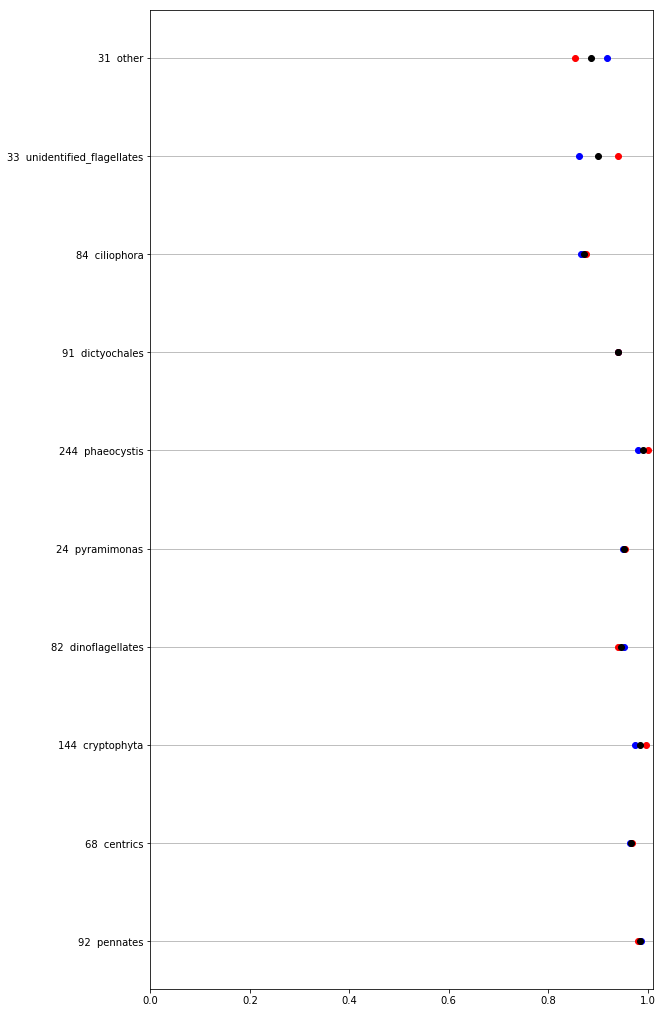

In [193]:
nc = [str(n) + '  ' + m for m,n in zip(names,counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

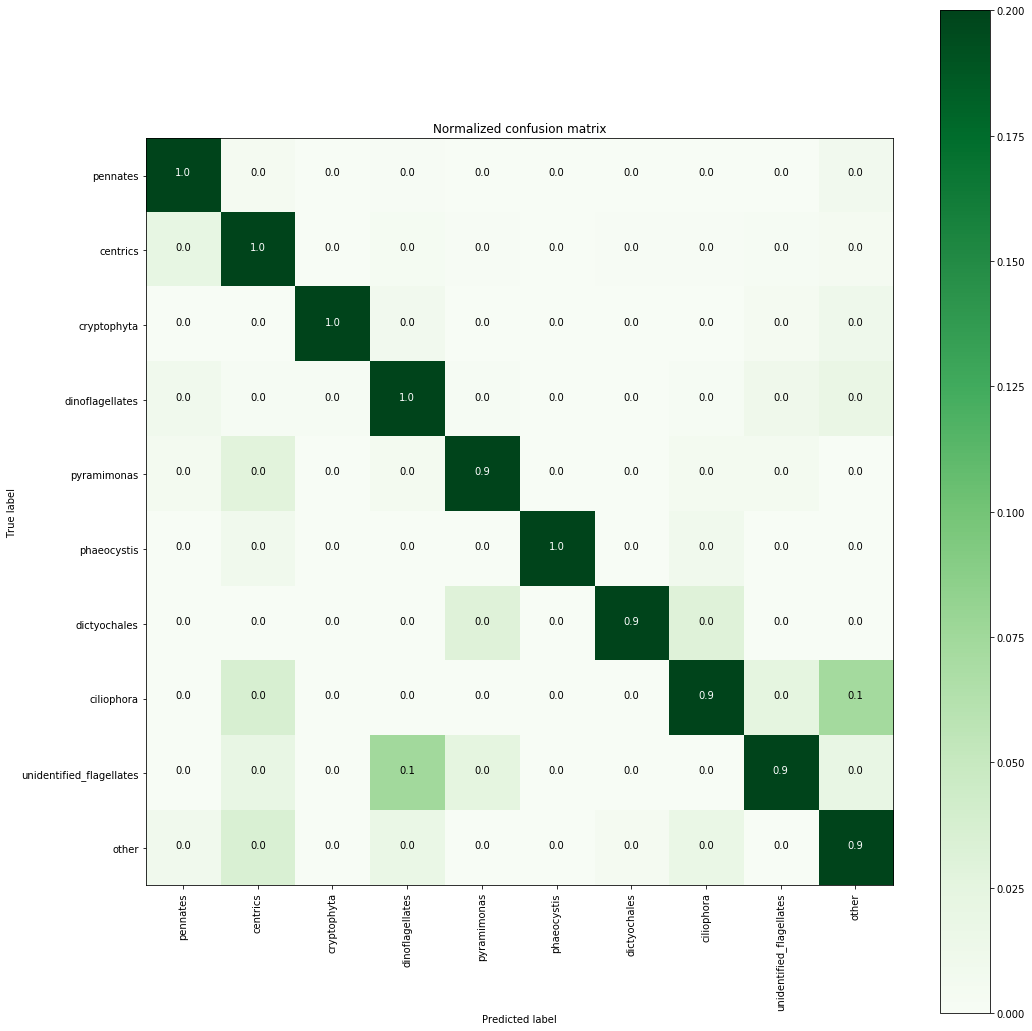

In [194]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))], rotation=90)
plt.yticks(tick_marks, [id_class_dict[i] for i in range(len(id_class_dict))])

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_most_merged.png', dpi=300)